### Imports

In [2]:
import os

# If you want to see TensorFlow/XLA logs, remove this lines:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['XLA_FLAGS'] = '--xla_gpu_autotune_level=0'

from pathlib import Path
from util import kaggle_setup, split_data, model_test
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetV2B0
from keras.applications.efficientnet import preprocess_input
from keras.utils import plot_model
from keras.models import load_model
from keras.optimizers import RMSprop
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import  ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Flatten, Dense, Dropout

### Setting up kaggle.json
Upload `kaggle.json` file with your credentials if it's not already configured

In [2]:
kaggle_setup.setup_kaggle_credentials()

✅ kaggle.json already configured


### Data download

In [3]:
data_dir = Path('dataset')
download_link = 'kaggle datasets download -d nicolaspalomares/aedes-mosquitos-dataset-reduced -p ./dataset --unzip'

kaggle_setup.download_data(data_dir, download_link)

✅ dataset already downloaded


### Data split
```
train = 0.8
test = 0.1
val = 0.1
```

In [4]:
categories = ['aegypti', 'albopictus']
cat_dir = data_dir / 'aedes_aegypti_reduced'

split_data.make_subset(data_dir/'train', cat_dir, 0.8, categories)
split_data.make_subset(data_dir/'test', cat_dir, 0.5, categories)
split_data.make_subset(data_dir/'val', cat_dir, 1.0, categories)

split_data.remove_dir(cat_dir)

ℹ️ dataset/train already in dataset
ℹ️ dataset/test already in dataset
ℹ️ dataset/val already in dataset
ℹ️ dataset/aedes_aegypti_reduced does not exists or it isn't a directory


In [5]:
train_dir = data_dir/'train'
test_dir = data_dir/'test'
val_dir = data_dir/'val'

train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(224,224),
    batch_size=32,
    color_mode="rgb"
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(224,224),
    batch_size=32,
    color_mode="rgb"
)

val_dataset = image_dataset_from_directory(
    val_dir,
    image_size=(224,224),
    batch_size=32,
    color_mode="rgb"
)

for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

Found 850 files belonging to 2 classes.


I0000 00:00:1760916152.523333    8593 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1765 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 106 files belonging to 2 classes.
Found 107 files belonging to 2 classes.
data batch shape: (32, 224, 224, 3)
labels batch shape: (32,)


### Training

Base model (EfficientNetV2B0)

In [7]:
directories = [
    "model",
    "model/plot",
    "model/summaries"
]

for dir_name in directories:
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    else:
        print(f"ℹ️ {dir_name} already in dataset")

base_model = EfficientNetV2B0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

with open("model/summaries/EfficientNetV2B0_summary.txt", "w") as f:
    base_model.summary(print_fn=lambda x: f.write(x + "\n"))


ℹ️ model already in dataset
ℹ️ model/plot already in dataset
ℹ️ model/summaries already in dataset


I0000 00:00:1761105895.452619    1263 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1765 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Final dense layers

In [7]:
inputs = Input(shape=(224,224,3), name='Input')
x = preprocess_input(inputs)
x = base_model(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.25)(x)
outputs = Dense(units=2, activation='softmax', name='Output')(x)

final_model = Model(inputs, outputs)

final_model.compile(
    optimizer = RMSprop(learning_rate=1e-4),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

with open("model/summaries/final_model_summary.txt", "w") as f:
    final_model.summary(print_fn=lambda x: f.write(x + "\n"))
    

In [8]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=5
)

model_checkpoint = ModelCheckpoint(
    filepath='model/model.keras', 
    save_best_only=True, 
    monitor='val_loss'
)

callback_list = [early_stopping, model_checkpoint]

history = final_model.fit(
    train_dataset, 
    validation_data=val_dataset,
    epochs=60, 
    batch_size=32, 
    callbacks=callback_list
)

Epoch 1/60


I0000 00:00:1760916172.368351    8713 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.5871 - loss: 1.0913 - val_accuracy: 0.8598 - val_loss: 0.3850
Epoch 2/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.6835 - loss: 0.6799 - val_accuracy: 0.8224 - val_loss: 0.3609
Epoch 3/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 464ms/step - accuracy: 0.8047 - loss: 0.4717 - val_accuracy: 0.8879 - val_loss: 0.2392
Epoch 4/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 461ms/step - accuracy: 0.8188 - loss: 0.4675 - val_accuracy: 0.9159 - val_loss: 0.1993
Epoch 5/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 458ms/step - accuracy: 0.8553 - loss: 0.3479 - val_accuracy: 0.9439 - val_loss: 0.1850
Epoch 6/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 460ms/step - accuracy: 0.8671 - loss: 0.3650 - val_accuracy: 0.9533 - val_loss: 0.1414
Epoch 7/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 422ms/step - accuracy: 0.9176 - loss: 0.2202 - val_accuracy: 0.9439 - val_loss: 0.1546
Epoch 8/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 454ms/step - accuracy: 0.9141 - loss: 0.2573 - val_accuracy: 0.9533 -

In [9]:
metrics = pd.DataFrame(history.history)
metrics.tail()

,accuracy,loss,val_accuracy,val_loss
12,0.940000,0.177910,0.953271,0.191019
13,0.949412,0.135637,0.943925,0.092605
14,0.960000,0.115082,0.953271,0.183798
15,0.963529,0.089032,0.971963,0.079774
16,0.960000,0.132896,0.962617,0.168312


Accuracy and loss from training and validation

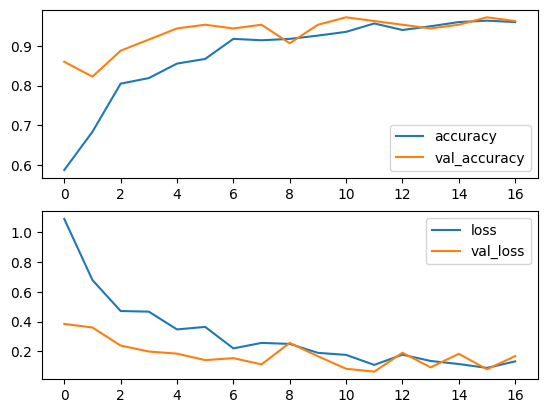

In [10]:
fig, axs = plt.subplots(2, 1)
metrics[['accuracy', 'val_accuracy']].plot(ax=axs[0])
metrics[['loss', 'val_loss']].plot(ax=axs[1])
plt.show()

Final model plot

In [11]:
plot_dir = Path("model/plot")

_ = plot_model(
    final_model, 
    to_file=plot_dir/'aedes_classifier.png', 
    show_dtype=True, 
    show_layer_activations=True, 
    show_layer_names=True, 
    show_shapes=True
)

### Testing the model

Classification Report:

              precision    recall  f1-score   support

     aegypti       0.88      0.98      0.93        54
  albopictus       0.98      0.87      0.92        52

    accuracy                           0.92       106
   macro avg       0.93      0.92      0.92       106
weighted avg       0.93      0.92      0.92       106



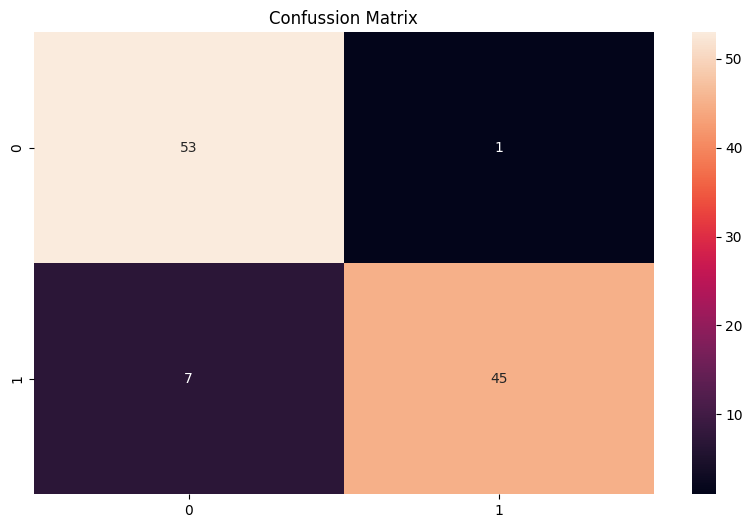

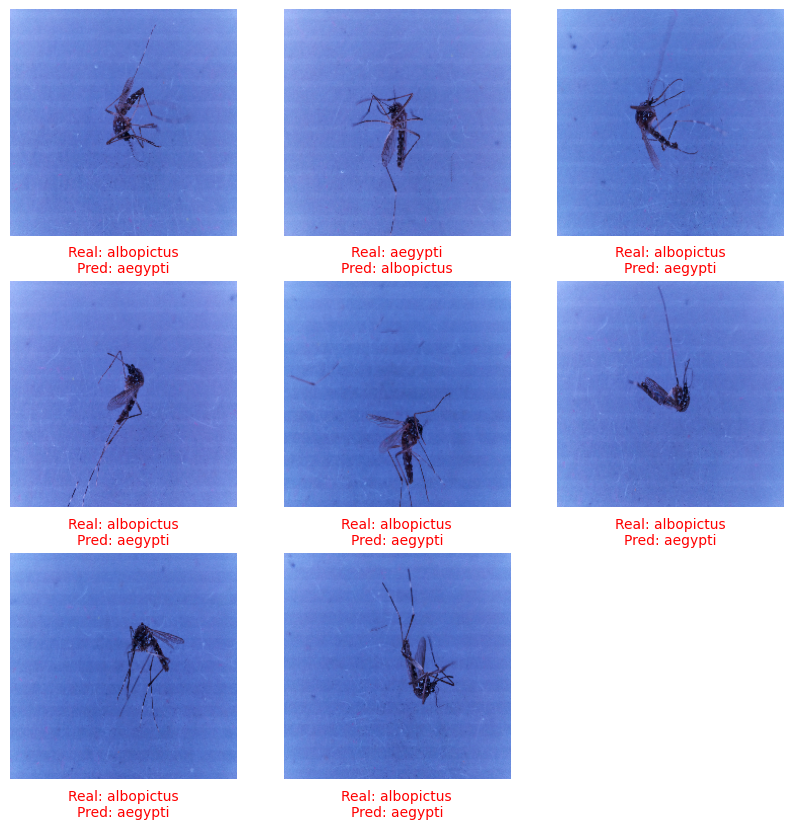

In [ ]:
model = load_model("model/model.keras")
model_test.get_results(model, test_dataset)